<a href="https://colab.research.google.com/github/piyadalal/Optimization_Using_Evolutionary_Algorithms/blob/master/MNIST_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example will perform character recognition through user input into the touch screen of an STM3240G-Evaluation board using the MNIST dataset.

In [21]:
#%tensorflow_version 2.x
#!apt-get install -y xxd

#! pip uninstall -y tensorflow
#! pip install -q tf-nightly
#! pip install -q tensorflow-model-optimization

import tensorflow as tf
from tensorflow import keras

(images_train, labels_train), (images_test, labels_test) = tf.keras.datasets.mnist.load_data()

Importing Tensorflow allows you to use its API to load the MNIST dataset. It should be noted that we need to use TF version <1.14 as this version includes the fully connected operation version 3 which is incompatible with the micro interpreters version 2.

3


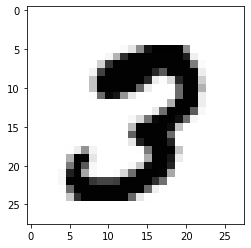

In [22]:
import matplotlib.pyplot as plt
test_index = 12345
print(labels_train[test_index])
plt.imshow(images_train[test_index], cmap='Greys')

The input of the neural network needs to know the input shape that it is going to be fed

In [23]:
input_shape = images_train.shape
print("{} images, each with shape of {} pixels x {} pixels".format(input_shape[0], input_shape[1], input_shape[2]))

60000 images, each with shape of 28 pixels x 28 pixels


The input shape for the model must be reshaped to 4D as the current shape does not show that each pixel is a 1D array where only the greyscale value (0-255) is stored. The input tensor's shape will be 3D as it will take a single-channel image. 

In [24]:
images_train = images_train.reshape(images_train.shape[0], images_train.shape[1], images_train.shape[2], 1)
images_test = images_test.reshape(images_test.shape[0], images_test.shape[1], images_test.shape[2], 1)
input_tensor_shape = (images_test.shape[1], images_test.shape[2], 1)
print("Input shape: {}".format(input_shape))

Input shape: (60000, 28, 28)


The greyscale values stores in the images' pixels are 8 bit values and need to be normalized into floats between 0-1.

In [25]:
images_train = images_train.astype('float32')
images_test = images_test.astype('float32')
images_train /= 255
images_test /= 255

In [26]:
#Counter initialization for iteration count
count=0

Create some classes for storing the layers

In [27]:
from enum import Enum, auto
import sys

class Conv2DArgs(Enum):
  'Args needed for creating Conv2DArgs layer, list not complete'
  FILTERS = auto()
  KERNEL_SIZE = auto()
  STRIDES = auto()
  INPUT_SIZE = auto()

class MaxPool2DArgs(Enum):
  'Args needed for creating MaxPool2D layer, list not complete'
  POOL_SIZE = auto()
  STRIDES = auto()

class ReshapeArgs(Enum):
  'Args needed for creating Reshape layer'
  TARGET_SHAPE = auto()

class DenseArgs(Enum):
  'Args needed for creating Dense layer, list not complete'
  UNITS = auto()
  ACTIVATION = auto()

class DropoutArgs(Enum):
  'Args needed for creating Dropout layer, list not complete'
  RATE = auto()

class ModelLayer:
  'Common layer properties'

  def __init__(self, name):
    self.name = name
    self.args = {}

class Conv2DLayer(ModelLayer):

  def __init__(self, filters, kernel_size, strides, input_size):
    super().__init__("Conv2D")
    self.args[Conv2DArgs.FILTERS.name] = filters
    self.args[Conv2DArgs.KERNEL_SIZE.name] = kernel_size
    self.args[Conv2DArgs.STRIDES.name] = strides
    self.args[Conv2DArgs.INPUT_SIZE.name] = input_size 

  def getkeraslayer(self):
    return keras.layers.Conv2D(
        self.args.get(Conv2DArgs.FILTERS.name), 
        kernel_size=self.args.get(Conv2DArgs.KERNEL_SIZE.name), 
        strides=self.args.get(Conv2DArgs.STRIDES.name), 
        input_shape=self.args.get(Conv2DArgs.INPUT_SIZE.name))

class MaxPool2DLayer(ModelLayer):

  def __init__(self, pool_size, strides):
    super().__init__("MaxPool2D")
    self.args[MaxPool2DArgs.POOL_SIZE.name] = pool_size
    self.args[MaxPool2DArgs.STRIDES.name] = strides 

  def getkeraslayer(self):
    return keras.layers.MaxPool2D(
        pool_size=self.args.get(MaxPool2DArgs.POOL_SIZE.name),
        strides=self.args.get(MaxPool2DArgs.STRIDES.name)
    )

class MaxPool3DLayer(MaxPool2DLayer):

  def __init__(self, pool_size, strides):
    super(MaxPool2DLayer, self).__init__("MaxPool3D")
    super().__init__(pool_size, strides)
    
  def getkeraslayer(self):
    return keras.layers.MaxPool3D(
        pool_size=self.args.get(MaxPool2DArgs.POOL_SIZE.name),
        strides=self.args.get(MaxPool2DArgs.STRIDES.name)
    )
  
class ReshapeLayer(ModelLayer):

  def __init__(self, target_shape):
    super().__init__("Reshape")
    self.args[ReshapeArgs.TARGET_SHAPE.name] = target_shape

  def getkeraslayer(self):
    return keras.layers.Reshape(self.args.get(ReshapeArgs.TARGET_SHAPE.name))

class DenseLayer(ModelLayer):

  def __init__(self, units, activation):
    super().__init__("Dense")
    self.args[DenseArgs.UNITS.name] = units
    self.args[DenseArgs.ACTIVATION.name] = activation

  def getkeraslayer(self):
    return keras.layers.Dense(self.args.get(DenseArgs.UNITS.name), 
                              activation=self.args.get(DenseArgs.ACTIVATION.name))

class FlattenLayer(ModelLayer):

  def __init__(self):
    super().__init__("Flatten")

  def getkeraslayer(self):
    return keras.layers.Flatten()

class Dropout(ModelLayer):

  def __init__(self, rate):
    super().__init__("Dropout")
    self.args[DropoutArgs.RATE.name] = rate
  
  def getkeraslayer(self):
    return keras.layers.Dropout(self.args.get(DropoutArgs.RATE.name))
  
class Model:

  def __init__(self, json, optimizer='adam', 
               loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    self.optimizer = optimizer
    self.loss = loss
    self.metrics = metrics
    self.layers = []

    for x in range(len(json.keys())):
      layer = json.get(str(x))
      name = layer.get('name')
      args = layer.get('args')
      if name == "Conv2D":
        filters = args.get(Conv2DArgs.FILTERS.name)
        kernel_size = tuple(args.get(Conv2DArgs.KERNEL_SIZE.name))
        strides = args.get(Conv2DArgs.STRIDES.name, (1,1))
        input_size = tuple(args.get(Conv2DArgs.INPUT_SIZE.name))
        self.layers.append(Conv2DLayer(filters, kernel_size, strides, input_size))
        print("Created {} layer with {} filters, {} kernel size, {} stride size and {} input size".format(
          name, filters, kernel_size, strides, input_size
        ))
      elif name == "MaxPool2D" or name == "MaxPool3D":
        pool_size = args.get(MaxPool2DArgs.POOL_SIZE.name)
        strides = args.get(MaxPool2DArgs.STRIDES.name, None)
        if name == "MaxPool2D":
          self.layers.append(MaxPool2DLayer(pool_size, strides))
          print("Created {} layer with {} pool size and {} stride size".format(
              name, pool_size, strides
          ))
        else:
          self.layers.append(MaxPool3DLayer(pool_size, strides))
          print("Created {} layer with {} pool size and {} stride size".format(
              name, pool_size, strides
          ))
      elif name == "Reshape":
        target_shape = args.get(ReshapeArgs.TARGET_SHAPE.name)
        self.layers.append(ReshapeLayer(target_shape))
        print(" Created {} layer with {} target shape".format(name, target_shape))
      elif name == "Dense":
        units = args.get(DenseArgs.UNITS.name)
        activation = getattr(tf.nn, args.get(DenseArgs.ACTIVATION.name))
        self.layers.append(DenseLayer(units, activation))
        print("Created {} layer with {} units and {} activation".format(name, units, activation))
      elif name == "Flatten":
        self.layers.append(FlattenLayer())
        print("Create {} layer".format(name))
      elif name == "Dropout":
        rate = args.get(DropoutArgs.RATE.name)
        self.layers.append(Dropout(rate))
        print("Created {} layers with {} rate".format(name, rate))

  def gettfmodel(self):
    model = keras.Sequential()
    for layer in self.layers:
      model.add(layer.getkeraslayer())

    model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
    return model


Random Number Generator for generating random combination of input parameters 

In [28]:
#Random Number generator 
import random

# I figure we can just call the layers '0', '1',...etc and this "name" is then the layer's index in the model
Model_Configuration1= {
        
    0: {
      'name': 'Conv2D',
      'args':  {
          Conv2DArgs.FILTERS.name: 28,
          Conv2DArgs.KERNEL_SIZE.name: [3,3],
          Conv2DArgs.INPUT_SIZE.name: [28,28,1]
          }
    }, 
    1: {
      'name': 'MaxPool2D',
      'args':  {
          MaxPool2DArgs.POOL_SIZE.name: [2, 2],
        }
    },
    2: {
      'name': 'Flatten'
    },
    3: {
      'name': 'Dense',
      'args': {
          DenseArgs.UNITS.name: 128,
          DenseArgs.ACTIVATION.name: "relu"
        }   
    },
    4: {
        'name': 'Dropout',
        'args':{
            DropoutArgs.RATE.name: 0.2
        }
    },
    5: {
        'name' : 'Dense',
        'args': {
        DenseArgs.UNITS.name: 128,
        DenseArgs.ACTIVATION.name: "softmax"
      }   
    } 
}

Model_Configuration4 = {
    0: {
        'name': 'Conv2D',
        'args': {
          Conv2DArgs.FILTERS.name: 12,
          Conv2DArgs.KERNEL_SIZE.name: [3,3],
          Conv2DArgs.STRIDES.name: [2,2],
          Conv2DArgs.INPUT_SIZE.name: [28,28,1]
          }
    },
    1: {
        'name': 'Reshape',
        'args': {
            ReshapeArgs.TARGET_SHAPE.name: [13,13,12,1]
        }
    },
    2: {
        'name': "MaxPool3D",
        'args':  {
          MaxPool2DArgs.POOL_SIZE.name: [6, 3, 3],
        }
    },
    3: {
        'name': 'Flatten'
    },
    4: {
        'name' : 'Dense',
        'args': {
        DenseArgs.UNITS.name: 128,
        DenseArgs.ACTIVATION.name: "softmax"
      } 
    }
}


Input configuration JSON file is used to store list of different combination of Input parameters.

In [29]:
#Appending procedure JSON
import os
import random

def write_json(json_model, filename):
  with open("{}.json".format(filename), mode='w+') as f:
      f.write(json.dumps(json_model, indent=2))

def load_json(filename):
  if os.path.isfile("{}.json".format(filename)):
    with open("{}.json".format(filename)) as f:
        return json.load(f)


Loading the parameters from JSON file as input to our Model.

In [ ]:
# # get model configuration params from our json file which is being appended
import json

write_json(Model_Configuration1, "test")

test_read = load_json("test")

test_model = Model(test_read)

tf_model = test_model.gettfmodel()

write_json(Model_Configuration4, "test4")

test_read4 = load_json("test4")

test_model4 = Model(test_read4)

tf_model4 = test_model4.gettfmodel()

batch_size = 100
epochs = 10

history = tf_model.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
tf_model.summary()
history4 = tf_model4.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
tf_model4.summary()


Created Conv2D layer with 28 filters, (3, 3) kernel size, (1, 1) stride size and (28, 28, 1) input size
Created MaxPool2D layer with [2, 2] pool size and None stride size
Create Flatten layer
Created Dense layer with 128 units and <function relu at 0x7fde9c317bf8> activation
Created Dropout layers with 0.2 rate
Created Dense layer with 128 units and <function softmax_v2 at 0x7fde9acbebf8> activation
Created Conv2D layer with 12 filters, (3, 3) kernel size, [2, 2] stride size and (28, 28, 1) input size
 Created Reshape layer with [13, 13, 12, 1] target shape
Created MaxPool3D layer with [6, 3, 3] pool size and None stride size
Create Flatten layer
Created Dense layer with 128 units and <function softmax_v2 at 0x7fde9acbebf8> activation
Epoch 1/10
600/600 [==============================] - 3s 5ms/step - loss: 0.3492 - accuracy: 0.9047
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 0.1152 - accuracy: 0.9659
Epoch 3/10
600/600 [==============================] - 3

In [ ]:
# get model configuration params from our json file
# import json 
# with open('Model_Configuration.json') as example_data:
#     data = json.load(example_data)
# print(data['layer1']['layer1_name'])
# int(data['layer1']['param1'])


Now the convolutional NN that we will use to classify the input images taken from the touch screen will have the following layer structure

1. Conv2D
2. MaxPooling2D
3. Flatten
4. Dense
5. Dropout
11. Dense



In [ ]:
#layer types and shapes changed in each model

#import tensorflow_model_optimization as tfmot

#quantize_model = tfmot.quantization.keras.quantize_model
model = keras.Sequential()

if (data[count]['layer1']['layer1_name']=='Conv2D'):
    model.add(keras.layers.Conv2D(int(data[count]['layer1']['param1']), kernel_size=(int(data[count]['layer1']['param2']),int(data[count]['layer1']['param3'])), input_shape=input_tensor_shape))
if (data[count]['layer2']['layer2_name']=='Maxpool'):
    model.add(keras.layers.MaxPooling2D(pool_size=(int(data[count]['layer2']['param1']),int(data[count]['layer2']['param2']))))         
model.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(keras.layers.Dense(128, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10,activation=tf.nn.softmax))


#quantized_model5 = quantize_model(model5)

The Conv2D layer extracts features from the input image using filters that slide across the input image. In this case we will use 28 different filters to extract a large number of unique features that will then be used to classify each image in the later layers. Thus the output of this layer will have the shape (28, 28, 1, 28)

MaxPooling2D is used to reduce the output size of the convolutional layer by reducing each 2 x 2 unique chunk of the output down in to a singular value, this reducing the output's size by a factor of 4. This will reduce our (28, 28, 1, 28) tensor down to a (7, 7, 1, 28) tensor.

The Flatten layer then takes this 2D array (our image) and shapes it into a single dimension (1372).

The following Dense layer reduces the input 1372 values down into 128 classes, taking the first steps in classifying the image into on of the 10 output classes (0-9). This is done using the relu activation function.

The Dropout layer sets 20% of the tensor's values to 0 so as to reduce overfitting.

Finally the last Dense layer reduces the output value down to the 10 classes, each representing a digit between 0 and 9. This is done using the softmax activation function which makes the outputs a set of probabilities summing to 1.


Train the model

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#quantized_model5.compile(optimizer='adam',
              #loss='sparse_categorical_crossentropy',
              #metrics=['accuracy'])

batch_size = 100
epochs = 10

print("Model 1")
history = model.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model.summary()




Now we can evaluate our trained model using the test data

In [ ]:
res = model.evaluate(images_test, labels_test)
print("Model1 has an accuracy of {0:.2f}%".format(res[1] * 100))

# Adding the results to JSON file
stringlist = []
li =[]
model.summary(print_fn=lambda x: stringlist.append(x))
for st in stringlist:
    li.append(st)
    
result={
    'Iteration': str(count),
    'Accuracy is:' : str(res[1] * 100),
     '':str(li[16])
    
}
# with open("Objectives.json", "w") as jsonFile:
#     json.dump(result, jsonFile)



Writing our final results back to our JSON file

In [ ]:
#Appending procedure JSON
import os
a = []
if not os.path.isfile("/Users/priyadalal/Desktop/OutputObjective.json"):
    a.append(result)
    with open("/Users/priyadalal/Desktop/OutputObjective.json", mode='w') as f:
        f.write(json.dumps(a, indent=2))
else:
    with open("/Users/priyadalal/Desktop/OutputObjective.json") as feedsjson:
        feeds = json.load(feedsjson)

    feeds.append(result)
    with open("/Users/priyadalal/Desktop/OutputObjective.json", mode='w') as f:
        f.write(json.dumps(feeds, indent=2))

In [ ]:
#Updating our counter on completing the Iteration 
count=count+1